# 장애인 콜택시 대기시간 예측 프로젝트 데이터 처리
## 목표
- 기상 예보를 바탕으로, 장애인 콜택시 평균 대기 시간을 예측하기.
- 장애인 이동권 개선을 위하여서, 콜택시 대기시간을 예측하는 프로젝트이다.  
- 이를 통하여 장애인 콜택시를 이용하는 고객들의 불편사항을 개선하고 서비스의 품질을 높여 교통약자의 이동 편의 증진에 기여한다.
### 목차
1. **데이터 처리**  
    - 주기별 분석
    - 데이터 프레임 합치기
    - 데이터프레임 새로운 feature 생성(공휴일 및 휴무, 7일간 평균 대기 시간)
2. 데이터 분석  
3. 머신러닝 모델링  
    - (나머지 3달 데이터는 테스트, 나머지는 학습데이터로 활용)  
    - MAE, MAPE를 사용해 성능 높은 모델 선정  
- 데이터 출처 : [서울시설공단_장애인콜택시 일별 이용현황](https://www.data.go.kr/data/15057705/openapi.do)  

## 라이브러리 불러오기

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.filterwarnings(action='ignore') # pd 경고메시지 생략

## 데이터 불러오기

In [243]:
file1 = pd.read_csv('./data/open_data.csv')
file2 = pd.read_csv('./data/weather.csv')

In [244]:
display(file1.head(2))
display(file2.head(2))

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611


,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16


# 1. 데이터 처리
- 기본 정보 확인
- 두 데이터프레임 날짜 기준으로 합치기.  
    (단, file2의 경우 예보로 활용할 데이터이기 때문에 날짜를 하나 앞으로 당겨주어 데이터프레임을 합쳐준다.)  
- 주기별 분석을 위해 날짜 변수 추가해준다.

In [245]:
# 기준날짜 컬럼 추가
file1['time'] = pd.to_datetime(file1['기준일'])
file1.rename(columns ={'차량운행':'car_cnt',
                       '접수건':'request_cnt',
                       '탑승건': 'ride_cnt',
                       '평균대기시간':'waiting_time',
                       '평균요금':'fare',
                       '평균승차거리':'distance'}, inplace=True)
file2['time'] = pd.to_datetime(file2['Date'].shift(-1))

In [246]:
display(file1.head(2))
display(file2.head(2))

,기준일,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,time
0,2015-01-01,213,1023,924,23.2,2427,10764,2015-01-01
1,2015-01-02,420,3158,2839,17.2,2216,8611,2015-01-02


,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),time
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90,2012-01-02
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16,2012-01-03


In [247]:
# 데이터 프레임 합치기
df = pd.merge(file1, file2, on='time', how='left') # 데이터 프레임 합치기
df.drop(['기준일','Date'], axis=1, inplace=True) # 필요 없는 열 제거 (file1의 '기준일', file2의 'Date' 열)

df.head(2)

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,time,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,213,1023,924,23.2,2427,10764,2015-01-01,-1.6,-1.6,0.0,64.0,64.0,0.00
1,420,3158,2839,17.2,2216,8611,2015-01-02,-4.3,-9.8,0.0,52.0,33.0,9.79


In [248]:
# 주기별 컬럼 만들기
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['week'] = df['time'].dt.isocalendar().week
df['weekday'] = df['time'].dt.weekday

In [249]:
df.head(2)

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,time,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday
0,213,1023,924,23.2,2427,10764,2015-01-01,-1.6,-1.6,0.0,64.0,64.0,0.00,2015,1,1,3
1,420,3158,2839,17.2,2216,8611,2015-01-02,-4.3,-9.8,0.0,52.0,33.0,9.79,2015,1,1,4


## 주기별 분석

In [250]:
day_df = df.groupby('weekday').mean() # 일 별 평균 => 월:0 ~ 일:6
week_df = df.groupby('week').mean() # 주 별 평균
month_df = df.groupby('month').mean() # 월 별 평균
year_df = df.groupby('year').mean() # 년 별 평균

date_list = [day_df, week_df, month_df, year_df]

* 차량 운행수

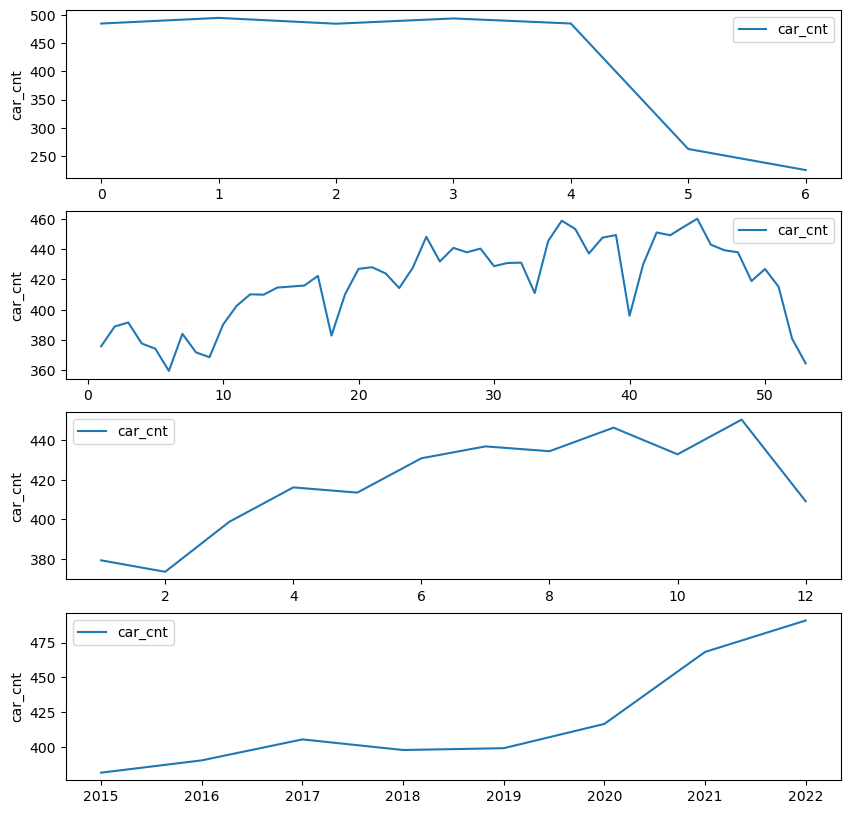

In [251]:
fig = plt.figure(figsize=(10, 10))

for n, date in enumerate(date_list):
    plt.subplot(4,1, n+1)
    sns.lineplot(x=np.array(date.index, dtype=float), y='car_cnt', data=date, label='car_cnt')

* 접수건, 탑승건

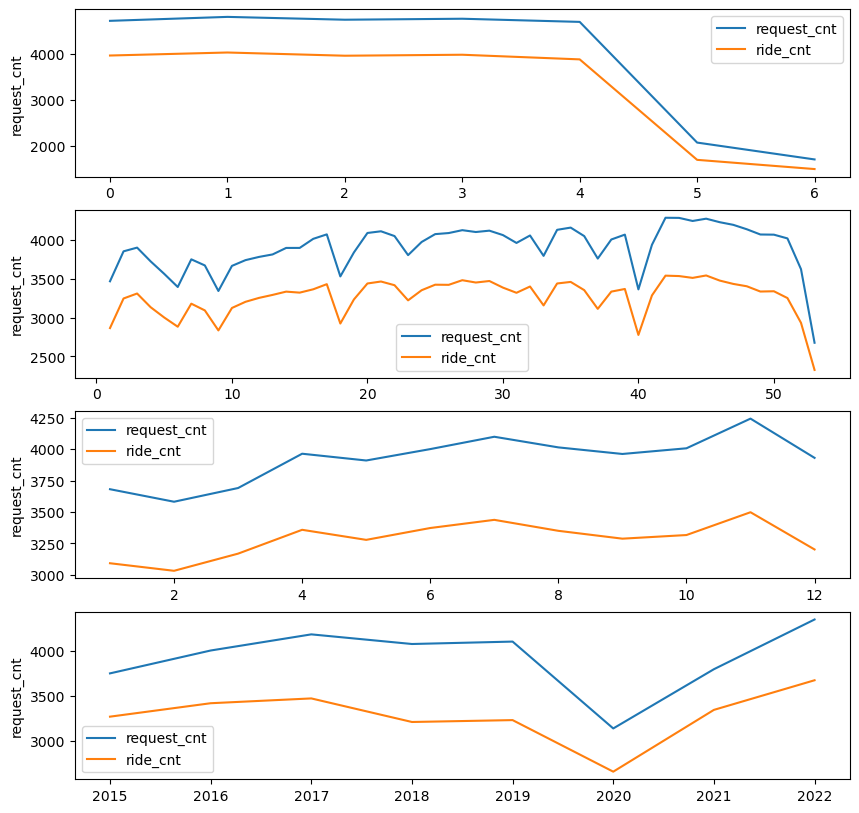

In [252]:
fig = plt.figure(figsize=(10, 10))

for n, date in enumerate(date_list):
    plt.subplot(4,1, n+1)
    sns.lineplot(x=np.array(date.index, dtype=float), y='request_cnt', data=date, label='request_cnt')
    sns.lineplot(x=np.array(date.index, dtype=float), y='ride_cnt', data=date, label='ride_cnt')

* 대기시간

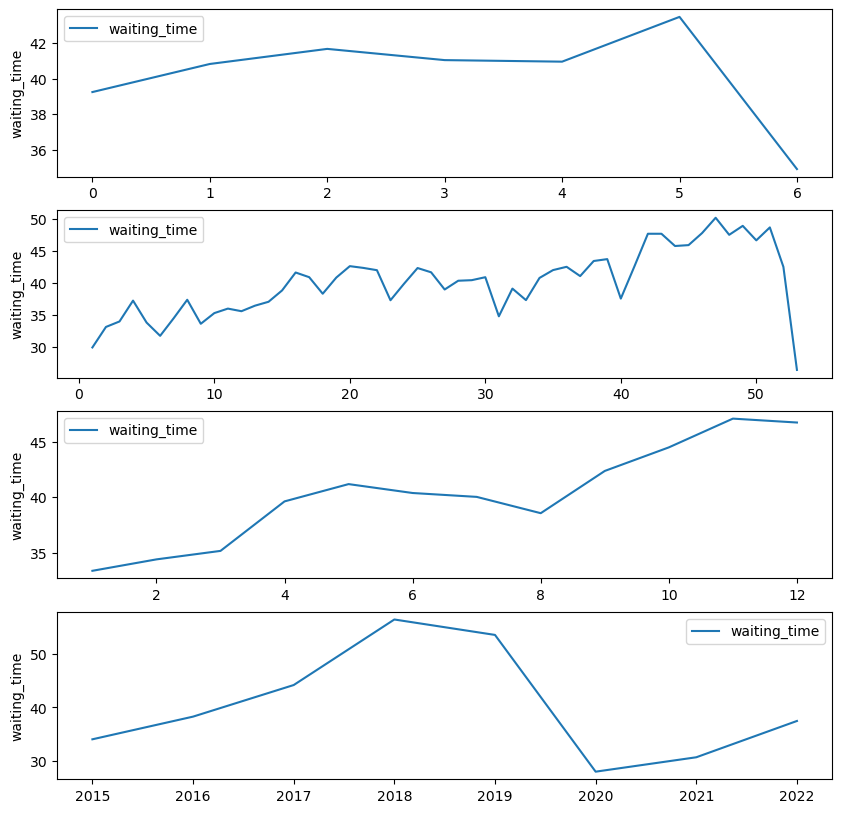

In [253]:
fig = plt.figure(figsize=(10, 10))

for n, date in enumerate(date_list):
    plt.subplot(4,1, n+1)
    sns.lineplot(x=np.array(date.index, dtype=float), y='waiting_time', data=date, label='waiting_time')

* 운임

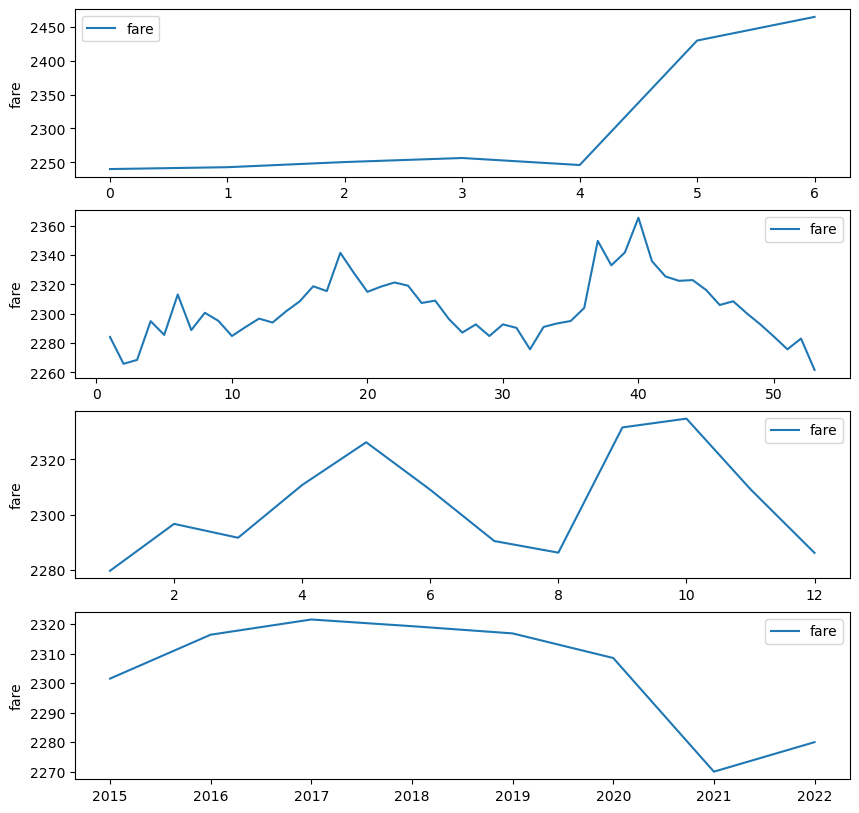

In [254]:
fig = plt.figure(figsize=(10, 10))

for n, date in enumerate(date_list):
    plt.subplot(4,1, n+1)
    sns.lineplot(x=np.array(date.index, dtype=float), y='fare', data=date, label='fare')

* 이동거리

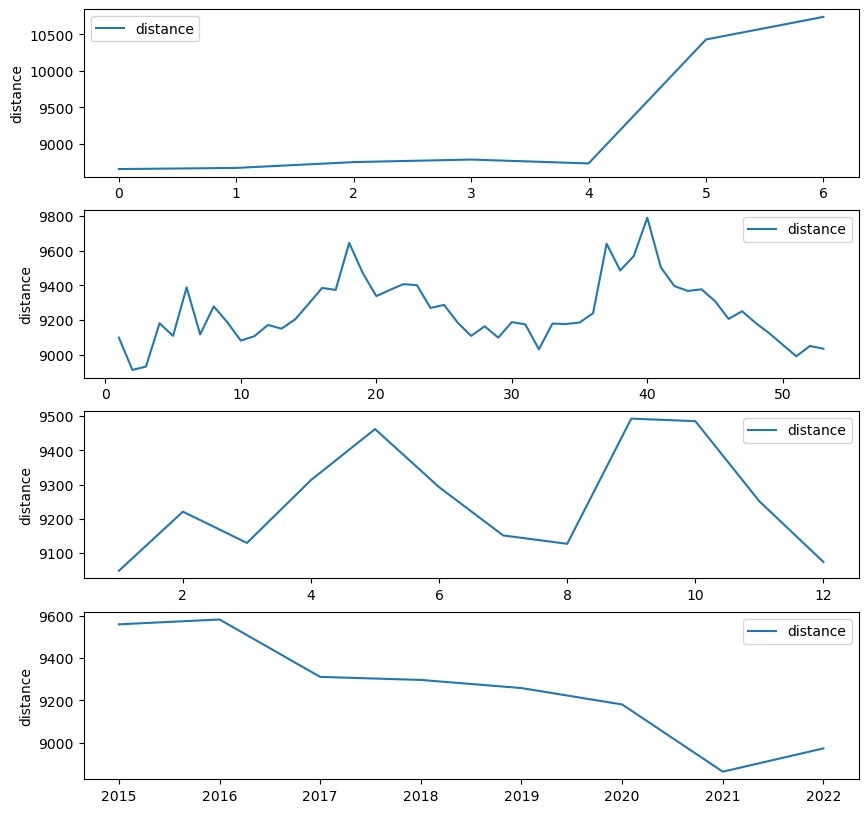

In [255]:
fig = plt.figure(figsize=(10, 10))

for n, date in enumerate(date_list):
    plt.subplot(4,1, n+1)
    sns.lineplot(x=np.array(date.index, dtype=float), y='distance', data=date, label='distance')

## 데이터 feature 추가
- 공휴일 및 휴일 정보 넣기
- 7일 이동 평균 대기 시간 넣기

In [256]:
df.head(2)

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,time,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday
0,213,1023,924,23.2,2427,10764,2015-01-01,-1.6,-1.6,0.0,64.0,64.0,0.00,2015,1,1,3
1,420,3158,2839,17.2,2216,8611,2015-01-02,-4.3,-9.8,0.0,52.0,33.0,9.79,2015,1,1,4


### 공휴일 정보 넣기
- 공휴일과 주말의 경우 0,
- 나머지 요일의 경우 1

In [257]:
# 공휴일 정보 불러오는 라이브러리 불러오기
from workalendar.asia import SouthKorea
cal = SouthKorea() # 객체 생성

# 공휴일 데이터프레임 만들기
holiday_df = pd.DataFrame() # 빈 데이터 프레임
for i in range(2015,2023): # 2015~2022년까지의 공휴일 데이터 프레임 완성
    tmp_df = pd.DataFrame(cal.holidays(i))
    holiday_df = pd.concat([holiday_df, tmp_df], axis=0)

holiday_df['time'] = pd.to_datetime(holiday_df[0]) # datetime으로 dtype변경
holiday_df = holiday_df[['time',1]] # 필요한 열 값만 남기기
holiday_df[1] = 1 # 데이터 처리

holiday_df.head(2)

,time,1
0,2015-01-01,1
1,2015-02-18,1


In [263]:
new_df = pd.merge(df, holiday_df, on='time', how='left') # 데이터프레임 합치기

new_df[1].loc[(new_df['weekday']==5) | (new_df['weekday']==6)] =1 # 데이터 값 변경 토요일과 일요일은 1
new_df = new_df.fillna(0) # Nan값 0으로 채워주기
new_df.rename(columns ={1:'holiday'}, inplace=True) # 컬럼명 변경

### 7일 이동평균 대기 시간

In [264]:
new_df['7days_waiting_time'] = new_df['waiting_time'].rolling(window=7).mean()
new_df.head(8)

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,time,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday,7days_waiting_time
0,213,1023,924,23.2,2427,10764,2015-01-01,-1.6,-1.6,0.0,64.0,64.0,0.00,2015,1,1,3,1.0,NaN
1,420,3158,2839,17.2,2216,8611,2015-01-02,-4.3,-9.8,0.0,52.0,33.0,9.79,2015,1,1,4,0.0,NaN
2,209,1648,1514,26.2,2377,10198,2015-01-03,-2.0,-8.9,0.0,63.0,28.0,9.07,2015,1,1,5,1.0,NaN
3,196,1646,1526,24.5,2431,10955,2015-01-04,2.4,-9.2,0.0,73.0,37.0,8.66,2015,1,1,6,1.0,NaN
4,421,4250,3730,26.2,2214,8663,2015-01-05,8.2,0.2,0.0,89.0,58.0,5.32,2015,1,2,0,0.0,NaN
5,417,3991,3633,23.6,2211,8545,2015-01-06,7.9,-0.9,0.0,95.0,52.0,6.48,2015,1,2,1,0.0,NaN
6,410,4085,3676,24.7,2230,8646,2015-01-07,4.1,-7.4,3.4,98.0,29.0,10.47,2015,1,2,2,0.0,23.657143
7,419,4030,3728,21.2,2231,8683,2015-01-08,-1.0,-8.8,0.0,42.0,24.0,10.12,2015,1,2,3,0.0,23.371429


## 데이터 저장

In [266]:
new_df = new_df.set_index(keys='time') # index 설정
new_df = new_df.sort_index(ascending=True) # index 기준 정렬

In [272]:
new_df.to_csv('./data/df.csv')
joblib.dump(new_df, './data/df.pkl')

['./data/df.pkl']